In [1]:
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.nn import functional as F
from torch import Tensor
from dataclasses import dataclass
from typing import Callable, List
from tqdm.notebook import tqdm
from sklearn.datasets import make_circles

plt.style.use("ggplot")

In [2]:
DEVICE = torch.device(type="cuda", index=0)

In [3]:
@dataclass
class Dataset:
    features: Tensor
    label: Tensor

In [4]:
def generate_data(
    n_samples: int,
    noise: float,
    device: torch.device
    ) -> Dataset:
    features = torch.rand(size=(n_samples, 1))
    features = features * 20 - 10
    label = torch.exp(-0.5 * torch.abs(features)) * torch.sin(2 * features)
    label = label + torch.randn(size=(n_samples, 1)) * noise
    return Dataset(
        features=features.to(device),
        label=label.to(device)
        )

In [5]:
def plot_dataset(ds: Dataset, ax: plt.Axes):
    ax.scatter(ds.features.cpu(), ds.label.cpu())
    ax.set(xlabel="$x$", ylabel="$y$")

In [6]:
ds = generate_data(
    n_samples=1000,
    noise=0.01,
    device=DEVICE
    )

In [7]:
ds.features.device

device(type='cuda', index=0)

In [8]:
ds.features.dtype

torch.float32

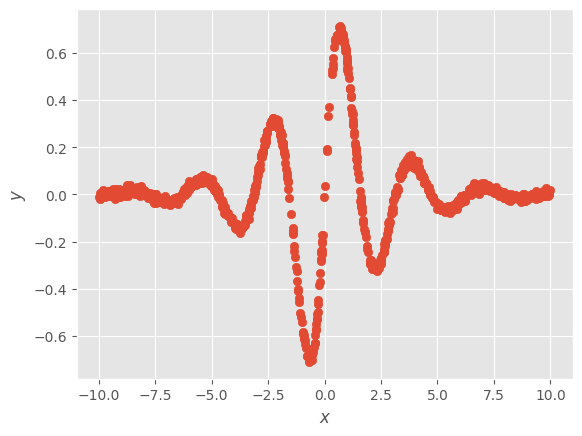

In [9]:
fig, ax = plt.subplots()
plot_dataset(ds, ax=ax)

$$
\mathbf{y} = \mathbf{X} \cdot \mathbf{w}
$$

In [10]:
class LinearRegression(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        """
        - En los parametros del constructor especificamos hiperparametros.
        - Inicializar las capas de la red neuronal.
        """
        super(LinearRegression, self).__init__()
        self.layer : nn.Module = nn.Linear(
            in_features=input_dim, out_features=output_dim
            ) # f(., w)

    def forward(self, features: Tensor) -> Tensor:
        """
        - Implementar la logica del modelo.
        - Especificar como se conecta la entrada (features) a la salida (return)
        """
        return self.layer(features) # f(x, w) = x @ w

In [11]:
model = LinearRegression(input_dim=1, output_dim=1)

In [12]:
model

LinearRegression(
  (layer): Linear(in_features=1, out_features=1, bias=True)
)

In [13]:
model_gpu = model.to(DEVICE)

In [14]:
model_gpu

LinearRegression(
  (layer): Linear(in_features=1, out_features=1, bias=True)
)

In [15]:
%%shell
nvidia-smi

Fri Nov 24 01:44:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    44W /  70W |    105MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
loss_fn = nn.MSELoss()

In [17]:
loss_fn

MSELoss()

In [18]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0147]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.5679], device='cuda:0', requires_grad=True)]

In [19]:
opt = optim.Adam(params=model.parameters(), lr=1e-3)

In [20]:
opt

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [21]:
LossFnType = Callable[[Tensor, Tensor], Tensor]

In [22]:
def train_step(
    ds: Dataset,
    model: nn.Module,
    loss_fn: LossFnType,
    opt: optim.Optimizer,
    ) -> Tensor:
    y_pred = model(ds.features)
    loss_val = loss_fn(y_pred, ds.label)

    opt.zero_grad()
    loss_val.backward()
    opt.step()
    return loss_val.detach().cpu()

In [23]:
def train(
    ds: Dataset,
    model: nn.Module,
    loss_fn: LossFnType,
    opt: optim.Optimizer,
    epochs: int
    ):
    pbar = tqdm(range(epochs))

    for i in pbar:
        loss_val = train_step(ds, model, loss_fn, opt)
        pbar.set_description(f"Epoch {i + 1}/{epochs} - Loss: {float(loss_val):.4f}")

In [24]:
train(ds, model, loss_fn, opt, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [25]:
def predict(features: Tensor, model: nn.Module) -> Dataset:
    y_pred = model(features).detach()
    return Dataset(features=features, label=y_pred)

In [26]:
ds_pred = predict(
    torch.linspace(-10, 10, 1000).reshape(-1, 1).to(DEVICE),
    model
    )

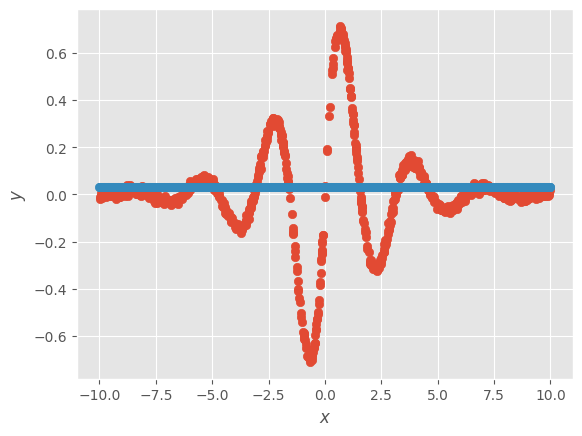

In [27]:
fig, ax = plt.subplots()
plot_dataset(ds, ax=ax)
plot_dataset(ds_pred, ax=ax)

- Linear regression:

$$
\tilde{\mathbf{y}} = \mathbf{X} \cdot \mathbf{w}
$$

- Multilinear Regression:

$$
\tilde{\mathbf{Y}} = \mathbf{X} \cdot \mathbf{W}
$$

- Logistic Regression

$$
\tilde{\mathbf{y}} = \frac{1}{1 + e ^ {\mathbf{X} \cdot \mathbf{w}}}
$$

- Multilogistic Regression

$$
\tilde{\mathbf{Y}} = \sigma(\mathbf{X} \cdot \mathbf{W})
$$

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Colored_neural_network.svg/1200px-Colored_neural_network.svg.png" width=50%>

$$
\mathbf{H_1} = f_1(\mathbf{X} \cdot \mathbf{W_1} + \mathbf{b_1})\\
\mathbf{Y} = f_2(\mathbf{H_1} \cdot \mathbf{W_2} + \mathbf{b_2})
$$

- $\mathbf{X} \in \mathbb{R} ^ {N \times 3}$
- $\mathbf{Y} \in \mathbb{R} ^ {N \times 2}$
- $\mathbf{H_1} \in \mathbb{R} ^ {N \times 4}$
- $\mathbf{W_1} \in \mathbb{R} ^ {3 \times 4}$
- $\mathbf{b_1} \in \mathbb{R} ^ {1 \times 4}$
- $\mathbf{W_2} \in \mathbb{R} ^ {4 \times 2}$
- $\mathbf{b_2} \in \mathbb{R} ^ {1 \times 2}$

In [28]:
class MyNeuralNet(nn.Module):
    def __init__(self):
        super(MyNeuralNet, self).__init__()
        self.layer1 = nn.Linear(in_features=3, out_features=4)
        self.layer2 = nn.Linear(in_features=4, out_features=2)

    def forward(self, features: Tensor) -> Tensor:
        h1 = F.sigmoid(self.layer1(features))
        y = F.sigmoid(self.layer2(h1))
        return y

In [29]:
model = MyNeuralNet()

In [30]:
model

MyNeuralNet(
  (layer1): Linear(in_features=3, out_features=4, bias=True)
  (layer2): Linear(in_features=4, out_features=2, bias=True)
)

In [31]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.4745, -0.4596,  0.4886],
         [ 0.3972, -0.2235, -0.3632],
         [ 0.0116,  0.2290,  0.4592],
         [ 0.0100,  0.5708, -0.1414]], requires_grad=True),
 Parameter containing:
 tensor([-0.2078,  0.0092, -0.3836,  0.4845], requires_grad=True),
 Parameter containing:
 tensor([[ 0.3832,  0.4037, -0.3066, -0.3957],
         [ 0.0427,  0.1626, -0.0873,  0.0335]], requires_grad=True),
 Parameter containing:
 tensor([-0.4055, -0.0325], requires_grad=True)]

In [32]:
ActivationType = Callable[[Tensor], Tensor]
class Dense(nn.Module):
    def __init__(self, in_features: int, out_features: int, activation_fn: ActivationType):
        super(Dense, self).__init__()
        self.activation_fn = activation_fn
        self.layer = nn.Linear(in_features=in_features, out_features=out_features)

    def forward(self, features: Tensor) -> Tensor:
        return self.activation_fn(self.layer(features))

In [33]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, neurons_per_layer: List[int], activations: List[ActivationType]):
        super(MultilayerPerceptron, self).__init__()
        self.layers = nn.Sequential(
            *(Dense(in_features, out_features, act_fn)
            for in_features, out_features, act_fn in zip(
                neurons_per_layer[:-1],
                neurons_per_layer[1:],
                activations
            ))
        )

    def forward(self, features: Tensor) -> Tensor:
        return self.layers(features)

In [34]:
model = MultilayerPerceptron(
    neurons_per_layer=[3, 4, 2],
    activations=[F.sigmoid, F.sigmoid]
)

In [35]:
model

MultilayerPerceptron(
  (layers): Sequential(
    (0): Dense(
      (layer): Linear(in_features=3, out_features=4, bias=True)
    )
    (1): Dense(
      (layer): Linear(in_features=4, out_features=2, bias=True)
    )
  )
)

In [36]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.1828,  0.1467,  0.4733],
         [ 0.2877,  0.3191, -0.2396],
         [-0.1216, -0.4292,  0.5282],
         [-0.1921,  0.1014, -0.2244]], requires_grad=True),
 Parameter containing:
 tensor([ 0.2245,  0.3374, -0.4091,  0.2172], requires_grad=True),
 Parameter containing:
 tensor([[-0.0798,  0.1226, -0.3500, -0.1476],
         [ 0.2896,  0.2413,  0.4947, -0.4479]], requires_grad=True),
 Parameter containing:
 tensor([0.0194, 0.0983], requires_grad=True)]

In [37]:
model = MultilayerPerceptron(
    neurons_per_layer=[1, 256, 128, 64, 32, 1],
    activations=[F.tanh, F.tanh, F.tanh, F.tanh, F.tanh]
).to(DEVICE)
opt = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
ds = generate_data(
    n_samples=1000,
    noise=0.01,
    device=DEVICE
    )

In [38]:
train(ds, model, loss_fn, opt, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [39]:
features_range = torch.linspace(-10, 10, 1000).reshape(-1, 1).to("cuda")
ds_pred = predict(features_range, model)

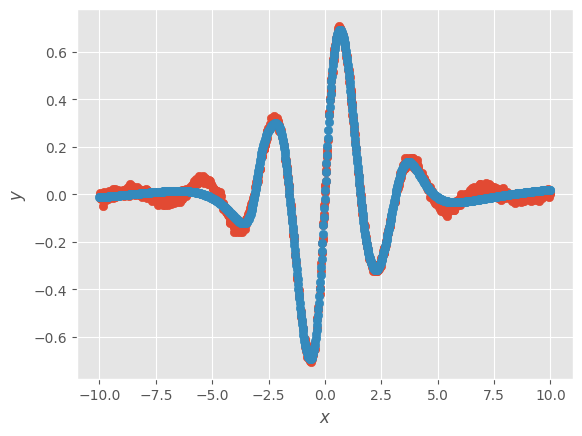

In [40]:
fig, ax = plt.subplots()
plot_dataset(ds, ax=ax)
plot_dataset(ds_pred, ax=ax)

In [41]:
def generate_circles(device: torch.device) -> Dataset:

    features, labels = make_circles(n_samples=1000, factor=0.2, noise=0.05)
    features = features.astype("float32")
    labels = labels.astype("int64")
    features = torch.tensor(features).to(device)
    labels = torch.tensor(labels).to(device)
    return Dataset(features=features, label=labels)

In [42]:
def plot_dataset(ds: Dataset, ax: plt.Axes, fig: plt.Figure):
    features = ds.features.cpu()
    scat = ax.scatter(
        features[:, 0],
        features[:, 1],
        c=ds.label.cpu(),
        cmap="RdBu",
        alpha=0.8
        )
    ax.set(xlabel="$x_1$", ylabel="$x_2$")
    fig.colorbar(scat)

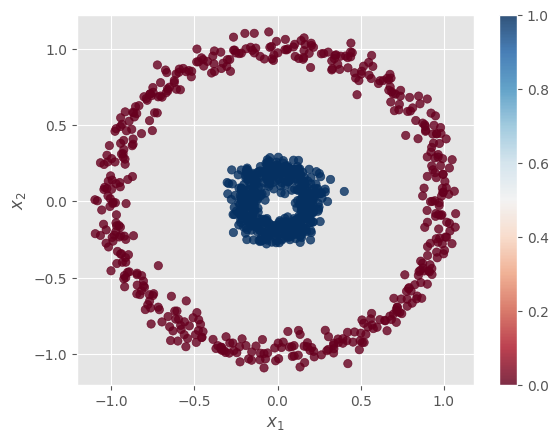

In [43]:
ds = generate_circles(DEVICE)
fig, ax = plt.subplots()
plot_dataset(ds, ax, fig)

In [47]:
nn.CrossEntropyLoss?

In [69]:
model = MultilayerPerceptron(
    neurons_per_layer=[2, 32, 16, 2],
    activations=[F.relu, F.relu, lambda x: x]
).to(DEVICE)
opt = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
ds = generate_circles(DEVICE)

In [70]:
ds.label.dtype

torch.int64

In [72]:
train(ds, model, loss_fn, opt, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [73]:
def predict(features: Tensor, model: nn.Module) -> Dataset:
    y_pred = F.softmax(model(features)).detach()
    return Dataset(features=features, label=y_pred[:, 1])

In [74]:
ds_pred = predict(ds.features, model)

<ipython-input-73-857f4a358949>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.softmax(model(features)).detach()


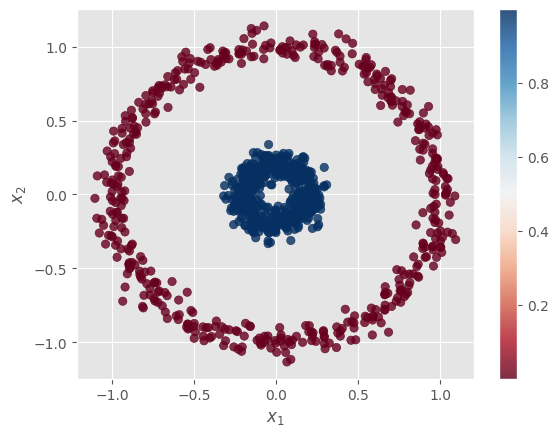

In [75]:
fig, ax = plt.subplots()
plot_dataset(ds_pred, ax, fig)

In [3]:
import torch

ModuleNotFoundError: ignored

In [4]:
!nvidia-smi

Thu Nov 23 20:59:49 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.05              Driver Version: 535.86.05    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce 940MX           On  | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P8              N/A / 200W |      3MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
!tree

.
├── build
│   ├── bdist.linux-x86_64
│   └── lib
│       └── nemono
│           └── __init__.py
├── dist
│   └── nemono-0.1.0-py3-none-any.whl
├── flake.lock
├── flake.nix
├── Makefile
├── README.md
├── requirements
│   ├── requirements_cpu_dev.txt
│   ├── requirements_cpu.txt
│   ├── requirements_gpu_dev.txt
│   └── requirements_gpu.txt
├── setup.py
└── src
    ├── nemono
    │   └── __init__.py
    └── nemono.egg-info
        ├── dependency_links.txt
        ├── PKG-INFO
        ├── requires.txt
        ├── SOURCES.txt
        └── top_level.txt

10 directories, 17 files
